In [15]:
from fredapi import Fred
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from functools import reduce

# pd.set_option('display.max_columns', None)  # or use a specific number if you know the column count
# pd.set_option('display.max_rows', None)  # or use a specific number if you know the row count
pd.set_option('display.max_colwidth', None)  # or use a large number like 1000


plt.style.use('ggplot')

In [2]:
# Load environment variables from .env file
load_dotenv()

api_key = os.getenv('FRED_API_KEY')

# Create the FRED Object
fred = Fred(api_key= api_key)

In [29]:
# # Search Fred for economic data
# sp_search = fred.search('S&P', order_by = 'popularity')

## Functions calling

In [3]:
def load_and_process_seasonal_data(data_fetcher, series_id, value_column, start_date='2018-01-01', 
                          resample_frequency='D', seasonal=7):
    """
    Loads and processes time series data from a given data source, handles missing values, 
    resamples to a given frequency, and applies STL decomposition.

    Parameters:
    - data_fetcher: Function to fetch the time series data (e.g., fred.get_series)
    - series_id: Identifier for the series to fetch (e.g., 'SP500')
    - value_column: Desired name for the value column in the output DataFrame
    - start_date: The start date for filtering the data
    - resample_frequency: The frequency to which the data should be resampled (e.g., 'D' for daily)
    - seasonal: Seasonal period for STL decomposition

    Returns:
    - A tuple of DataFrames: the resampled original and the seasonally adjusted data
    """
    # Fetch the time series data and set the column name
    series_data = data_fetcher(series_id)
    series_data.name = value_column
    df = series_data.to_frame().reset_index()

    # Convert the date column to datetime, set as index, and filter the data
    df['index'] = pd.to_datetime(df['index'])
    df = df.set_index('index')
    df = df[df.index >= start_date]

    # Resample and interpolate the data to handle missing values
    df_resampled = df.resample(resample_frequency).mean()
    df_resampled[value_column] = df_resampled[value_column].bfill().interpolate(method='linear')

    # Apply STL decomposition to extract the trend component
    stl = STL(df_resampled[value_column], seasonal=seasonal, robust=True)
    result = stl.fit()

    # Extract the seasonally adjusted series and convert to DataFrame
    df_adjusted = result.trend.to_frame(name=f'{value_column}_adjusted')

    return df_resampled.reset_index(), df_adjusted.reset_index()


In [4]:
def process_time_series_data(df, date_column='Date', value_column='Value', start_date='2018-01-01', resample_frequency='D', interpolate_method='linear'):
    """
    Processes time series data by filtering, cleaning, and resampling.

    Parameters:
    - df: DataFrame containing the time series data.
    - date_column: The column name in the DataFrame that contains the date information.
    - value_column: The column name in the DataFrame that contains the value to process.
    - start_date: The start date for filtering the data.
    - resample_frequency: The frequency to which the data should be resampled.
    - interpolate_method: The method used for interpolation during resampling.

    Returns:
    - A DataFrame with processed time series data.
    """
    # Convert date column to datetime and set as index
    df[date_column] = pd.to_datetime(df[date_column])
    df.set_index(date_column, inplace=True)

    # Filter based on start date and drop rows with missing target values
    filtered_df = df[df.index >= start_date].dropna(subset=[value_column])

    # Resample and interpolate the data
    resampled_df = filtered_df.resample(resample_frequency).interpolate(method=interpolate_method)

    # Reset the index to turn the date index back into a column
    return resampled_df.reset_index()

## S&P500

In [5]:
sp500_processed, sp500_adjusted = load_and_process_seasonal_data(fred.get_series, 'SP500', 'sp500')

### GDP

In [6]:
gdp_df = fred.get_series('GDP').to_frame('gdp').reset_index()
processed_gdp = process_time_series_data(gdp_df, date_column='index', value_column='gdp')

### Real GDP

In [7]:
real_gdp_df = fred.get_series('GDPC1').to_frame('rgdp').reset_index()
processed_real_gdp = process_time_series_data(real_gdp_df, date_column='index', value_column='rgdp')

### Unemployment Rate

In [8]:
unrate_df = fred.get_series('UNRATE').to_frame('unrate').reset_index()
processed_unrate_df = process_time_series_data(unrate_df, date_column='index', value_column='unrate')

### CPI

In [9]:
cpi_df = fred.get_series('CPIAUCSL').to_frame('cpi').reset_index()
processed_cpi_df = process_time_series_data(cpi_df, date_column='index', value_column='cpi')

### Interest Rate

In [10]:
int_rate_processed, int_rate_adjusted = load_and_process_seasonal_data(fred.get_series, 'REAINTRATREARAT10Y', 'interest_rate')

### Treasury constant maturity

In [11]:
treasure_df_processed, treasure_df_adjusted = load_and_process_seasonal_data(fred.get_series, 'T10Y2Y', 'treasure_maturity')

### Inflation Rate

In [12]:
inflation_rate_processed, inflation_rate_adjusted = load_and_process_seasonal_data(fred.get_series, 'T10YIE', 'inflation_rate')

### Sticky Price CPI Monthly Data

In [13]:
sticky_cpi_df = fred.get_series('CORESTICKM159SFRBATL').to_frame('sticky_cpi').reset_index()
processed_sticky_cpi_df = process_time_series_data(sticky_cpi_df, date_column='index', value_column='sticky_cpi')

### M2 Money Stock

In [14]:
m2_money_stock_processed, m2_money_stock_adjusted = load_and_process_seasonal_data(fred.get_series, 'WM2NS', 'm2_money_stock')

### Merge Datasets

In [18]:
# List of dataframes to merge
dataframes = [sp500_adjusted, processed_gdp, processed_real_gdp, processed_unrate_df, processed_cpi_df, int_rate_adjusted, treasure_df_adjusted, inflation_rate_adjusted, processed_sticky_cpi_df, m2_money_stock_adjusted]

# Merge dataframes using reduce function
merged_df = reduce(lambda left, right: pd.merge(left, right, on='index', how='outer'), dataframes)

In [315]:
merged_df.to_csv('fred_processed_data.csv', index=True)

# EDA

### S&P500

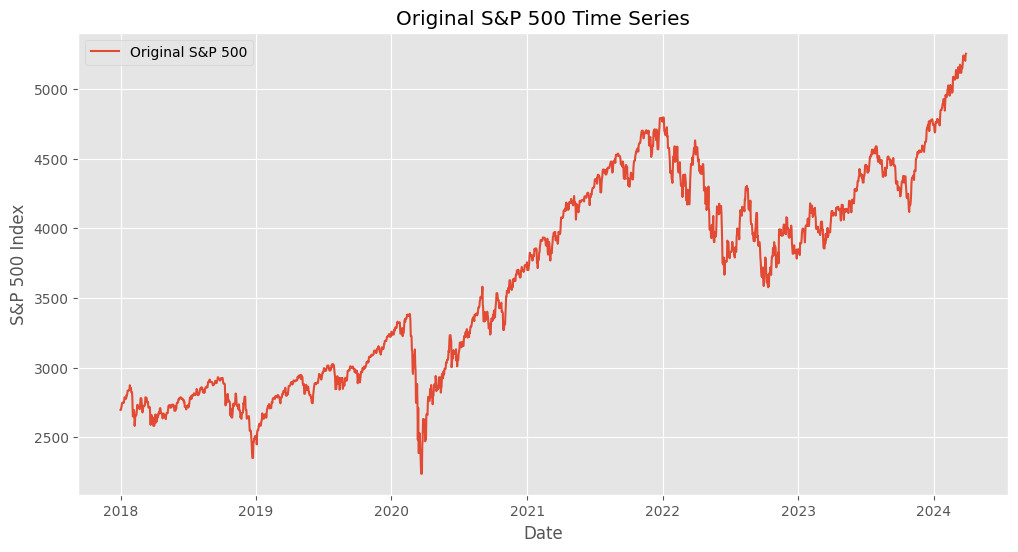

In [22]:
# Set the figure size and plot the original S&P 500 data
plt.figure(figsize=(12, 6))
plt.plot(sp500_processed['index'], sp500_processed['sp500'], label='Original S&P 500')
plt.title('Original S&P 500 Time Series')
plt.xlabel('Date')
plt.ylabel('S&P 500 Index')
plt.legend()
plt.grid(True)
plt.show()

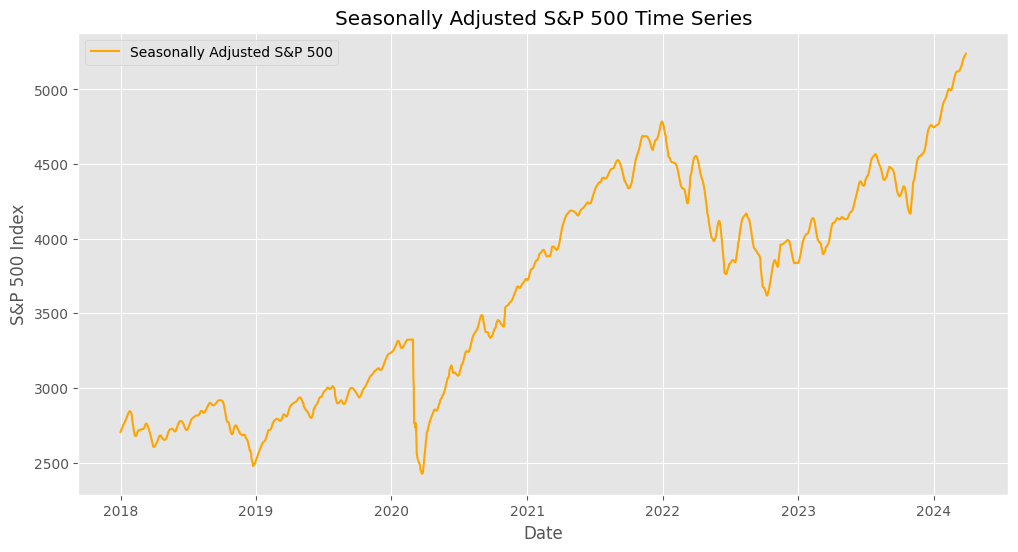

In [24]:
# Set the figure size and plot the seasonally adjusted S&P 500 data
plt.figure(figsize=(12, 6))
plt.plot(sp500_adjusted['index'], sp500_adjusted['sp500_adjusted'], label='Seasonally Adjusted S&P 500', color='orange')
plt.title('Seasonally Adjusted S&P 500 Time Series')
plt.xlabel('Date')
plt.ylabel('S&P 500 Index')
plt.legend()
plt.grid(True)
plt.show()


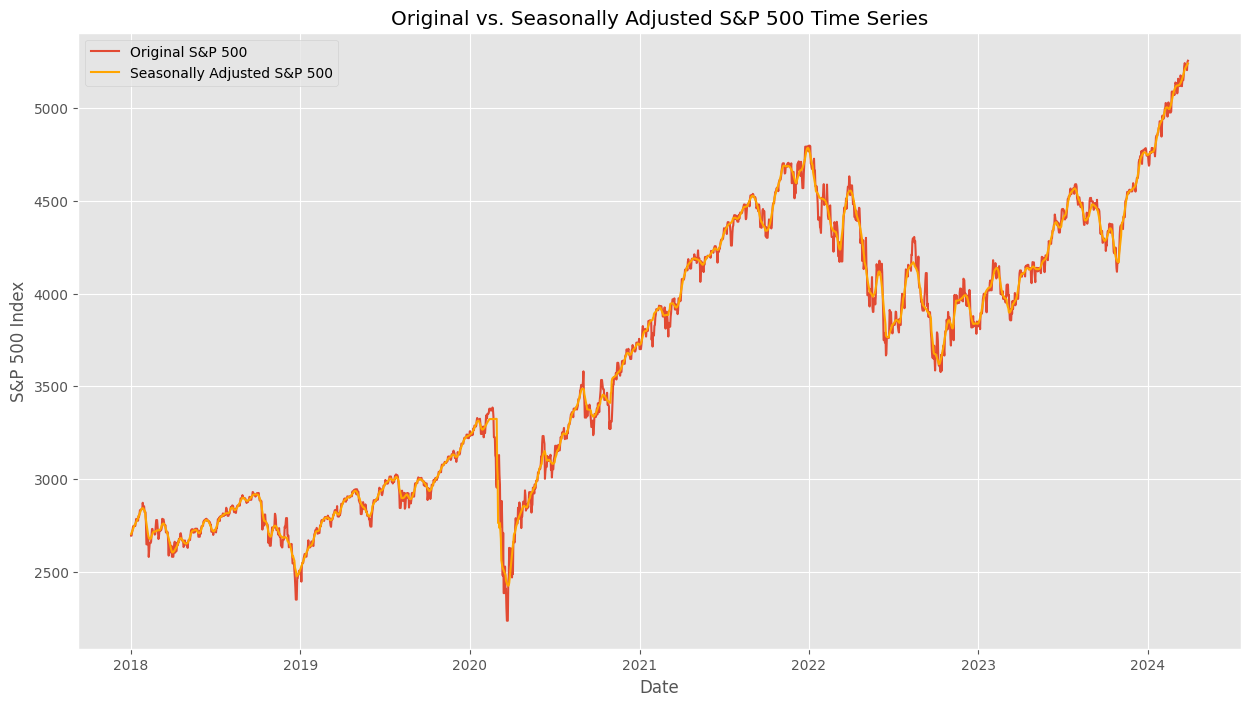

In [26]:
# Set the figure size and plot both the original and seasonally adjusted S&P 500 data on the same plot
plt.figure(figsize=(15, 8))
plt.plot(sp500_processed['index'], sp500_processed['sp500'], label='Original S&P 500')
plt.plot(sp500_adjusted['index'], sp500_adjusted['sp500_adjusted'], label='Seasonally Adjusted S&P 500', color='orange')
plt.title('Original vs. Seasonally Adjusted S&P 500 Time Series')
plt.xlabel('Date')
plt.ylabel('S&P 500 Index')
plt.legend()
plt.grid(True)
plt.show()


### GDP

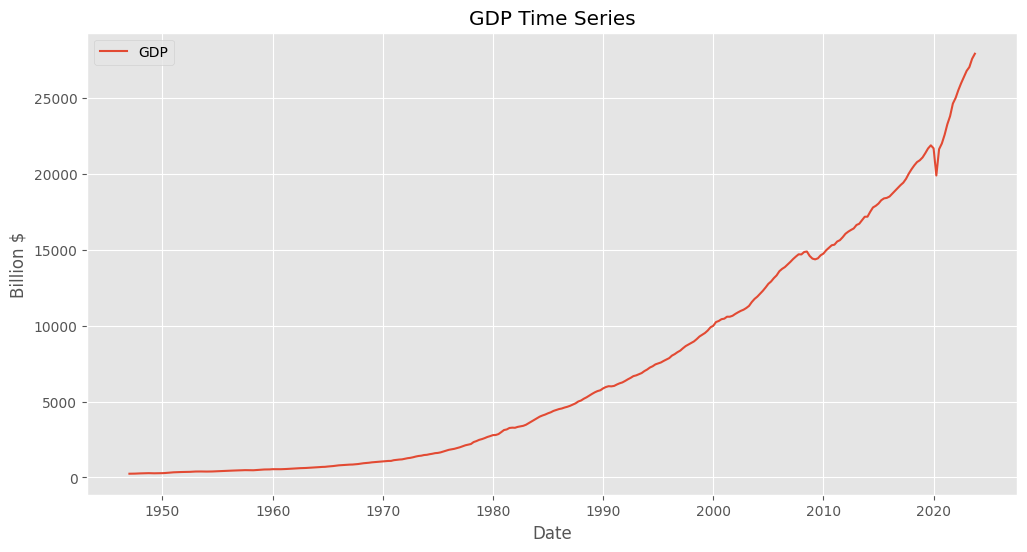

In [130]:
# Set the figure size and plot the original S&P 500 data
plt.figure(figsize=(12, 6))
plt.plot(gdp_df_cleaned.Date, gdp_df_cleaned['gdp'], label='GDP')
plt.title('GDP Time Series')
plt.xlabel('Date')
plt.ylabel('Billion $')
plt.legend()
plt.grid(True)
plt.show()

### Real GDP

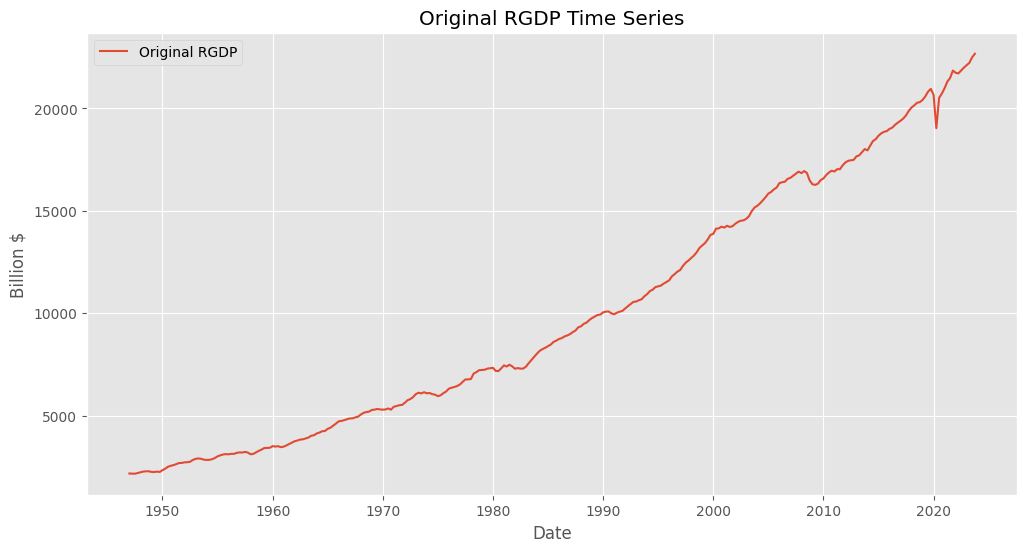

In [128]:
# Set the figure size and plot the original S&P 500 data
plt.figure(figsize=(12, 6))
plt.plot(real_gdp_df_cleaned.Date, real_gdp_df_cleaned['rgdp'], label='Original RGDP')
plt.title('Original RGDP Time Series')
plt.xlabel('Date')
plt.ylabel('Billion $')
plt.legend()
plt.grid(True)
plt.show()

### Unemployment Rate

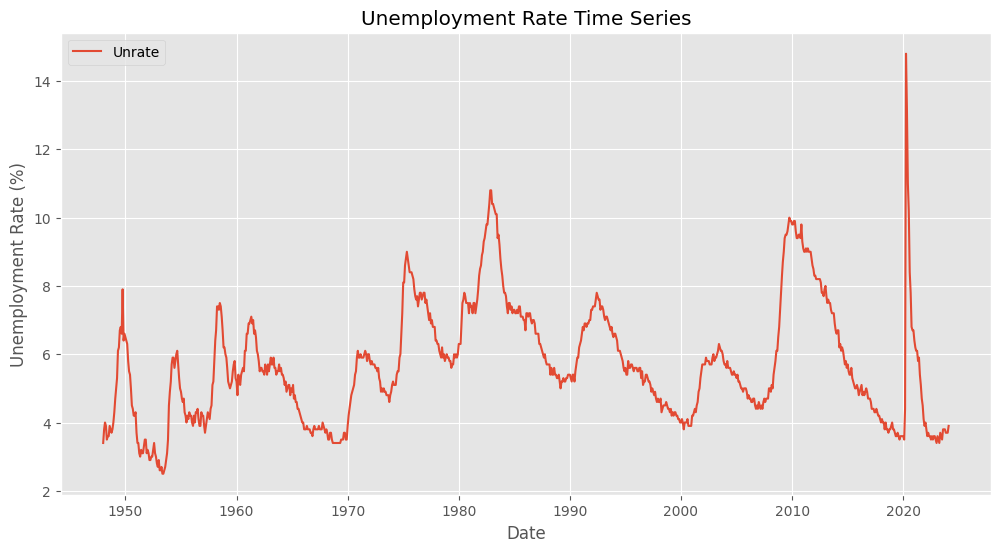

In [127]:
# Set the figure size and plot the original S&P 500 data
plt.figure(figsize=(12, 6))
plt.plot(unrate_df_cleaned.Date, unrate_df_cleaned['unrate'], label='Unrate')
plt.title('Unemployment Rate Time Series')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

### CPI

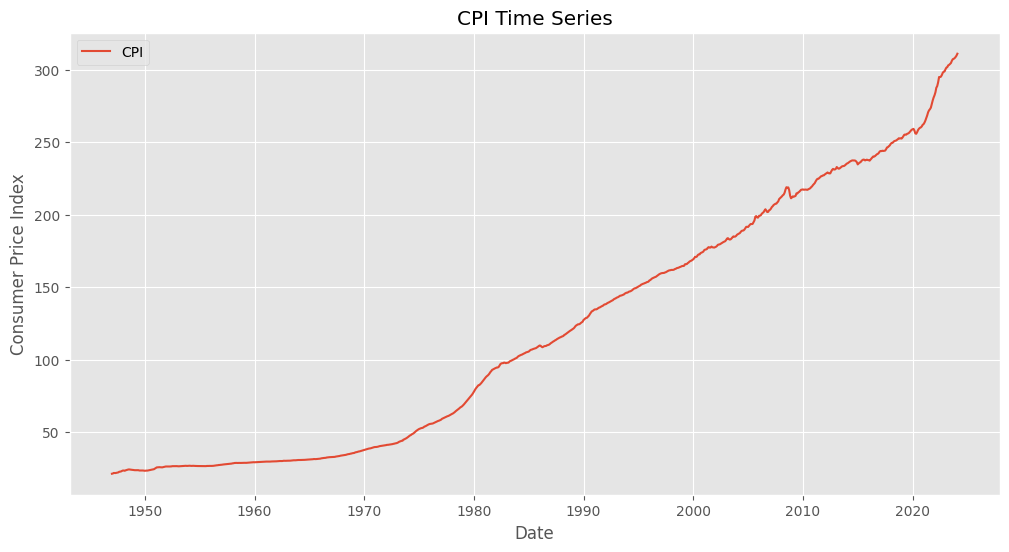

In [126]:
# Set the figure size and plot the original S&P 500 data
plt.figure(figsize=(12, 6))
plt.plot(cpi_df_cleaned.Date, cpi_df_cleaned['cpi'], label='CPI')
plt.title('CPI Time Series')
plt.xlabel('Date')
plt.ylabel('Consumer Price Index')
plt.legend()
plt.grid(True)
plt.show()


### Interest Rate

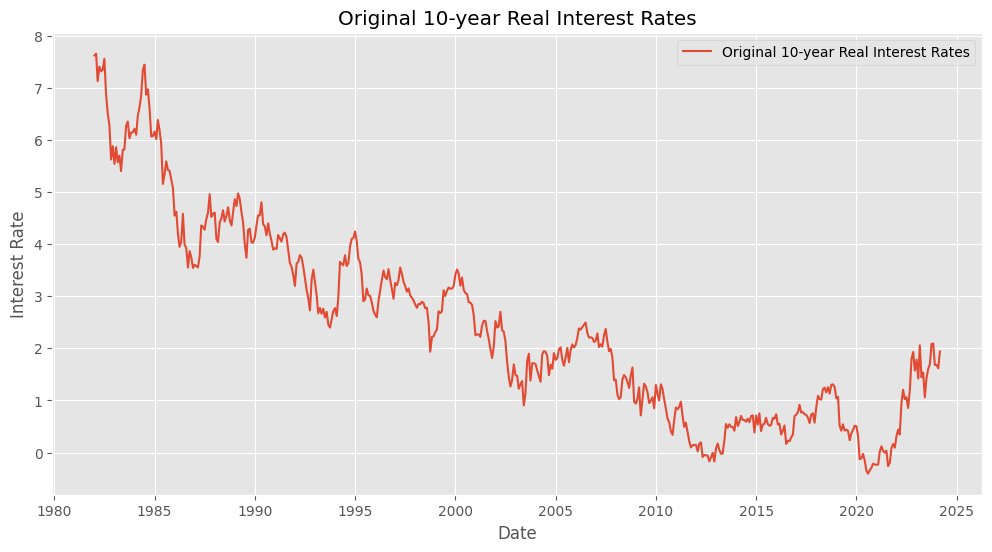

In [227]:
# Set the figure size and plot the original Interest Rate data
plt.figure(figsize=(12, 6))
plt.plot(int_rate_cleaned['Date'], int_rate_cleaned['interest_rates'], label='Original 10-year Real Interest Rate')
plt.title('Original 10-year Real Interest Rate')
plt.xlabel('Date')
plt.ylabel('10-year Real Interest Rate')
plt.legend()
plt.grid(True)
plt.show()

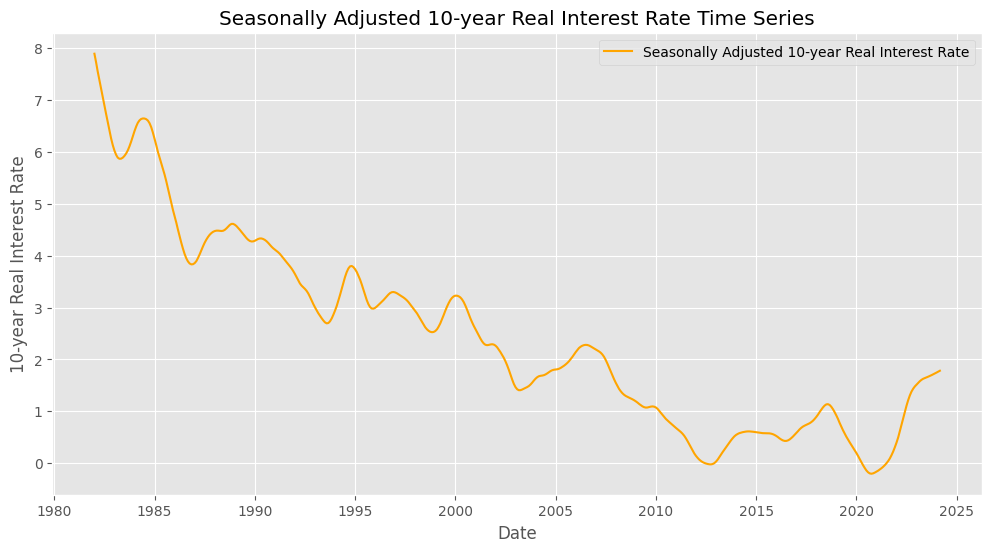

In [229]:
# Set the figure size and plot the seasonally adjusted Interest Rate data
plt.figure(figsize=(12, 6))
plt.plot(int_rate_adjusted['Date'], int_rate_adjusted['interest_rate'], label='Seasonally Adjusted 10-year Real Interest Rate', color='orange')
plt.title('Seasonally Adjusted 10-year Real Interest Rate Time Series')
plt.xlabel('Date')
plt.ylabel('10-year Real Interest Rate')
plt.legend()
plt.grid(True)
plt.show()

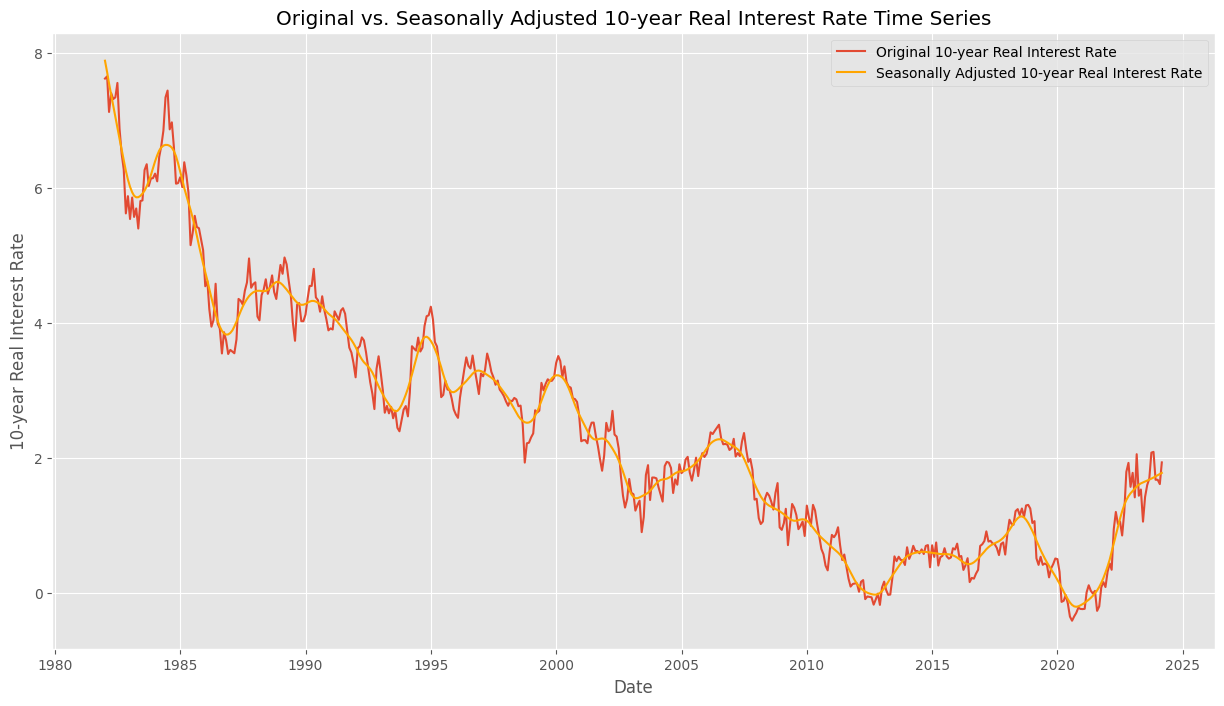

In [230]:
# Set the figure size and plot both the original and seasonally adjusted Interest Rate data on the same plot
plt.figure(figsize=(15, 8))
plt.plot(int_rate_cleaned['Date'], int_rate_cleaned['interest_rates'], label='Original 10-year Real Interest Rate')
plt.plot(int_rate_adjusted['Date'], int_rate_adjusted['interest_rate'], label='Seasonally Adjusted 10-year Real Interest Rate', color='orange')
plt.title('Original vs. Seasonally Adjusted 10-year Real Interest Rate Time Series')
plt.xlabel('Date')
plt.ylabel('10-year Real Interest Rate')
plt.legend()
plt.grid(True)
plt.show()


### Treasury constant Maturity

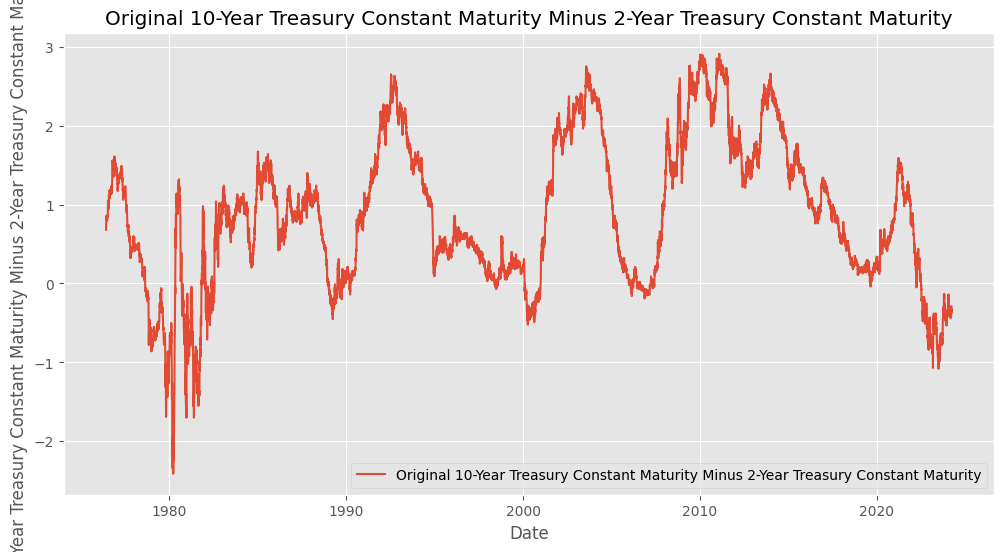

In [250]:
# Set the figure size and plot the original treasury maturity data
plt.figure(figsize=(12, 6))
plt.plot(treasure_df_1['Date'], treasure_df_1['treasure_maturity'], label='Original 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity')
plt.title('Original 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity')
plt.xlabel('Date')
plt.ylabel('10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity')
plt.legend()
plt.grid(True)
plt.show()

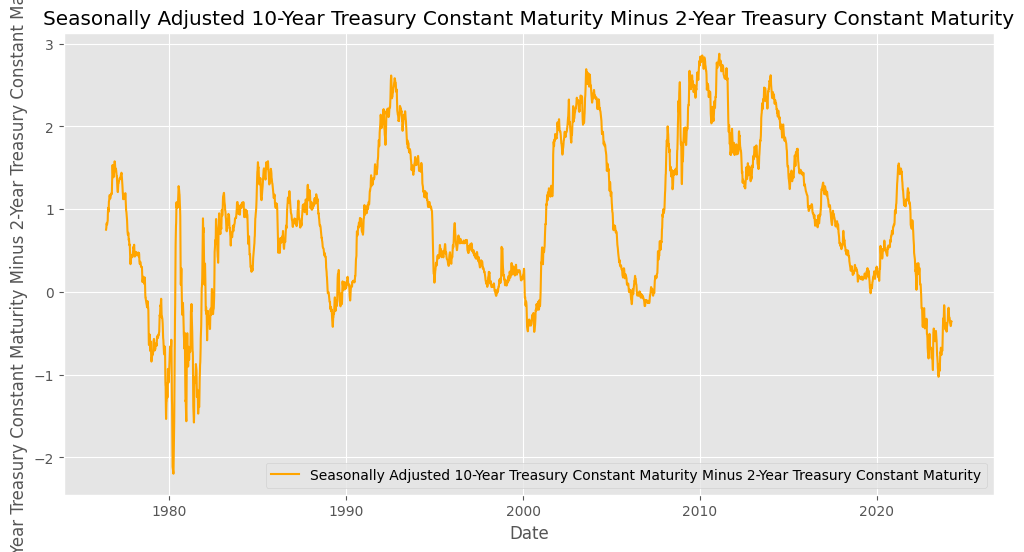

In [252]:
# Set the figure size and plot the original treasury maturity data
plt.figure(figsize=(12, 6))
plt.plot(treasure_mat_adjusted['Date'], treasure_mat_adjusted['treasure_maturity'], label='Seasonally Adjusted 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity', color='orange')
plt.title('Seasonally Adjusted 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity')
plt.xlabel('Date')
plt.ylabel('10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity')
plt.legend()
plt.grid(True)
plt.show()

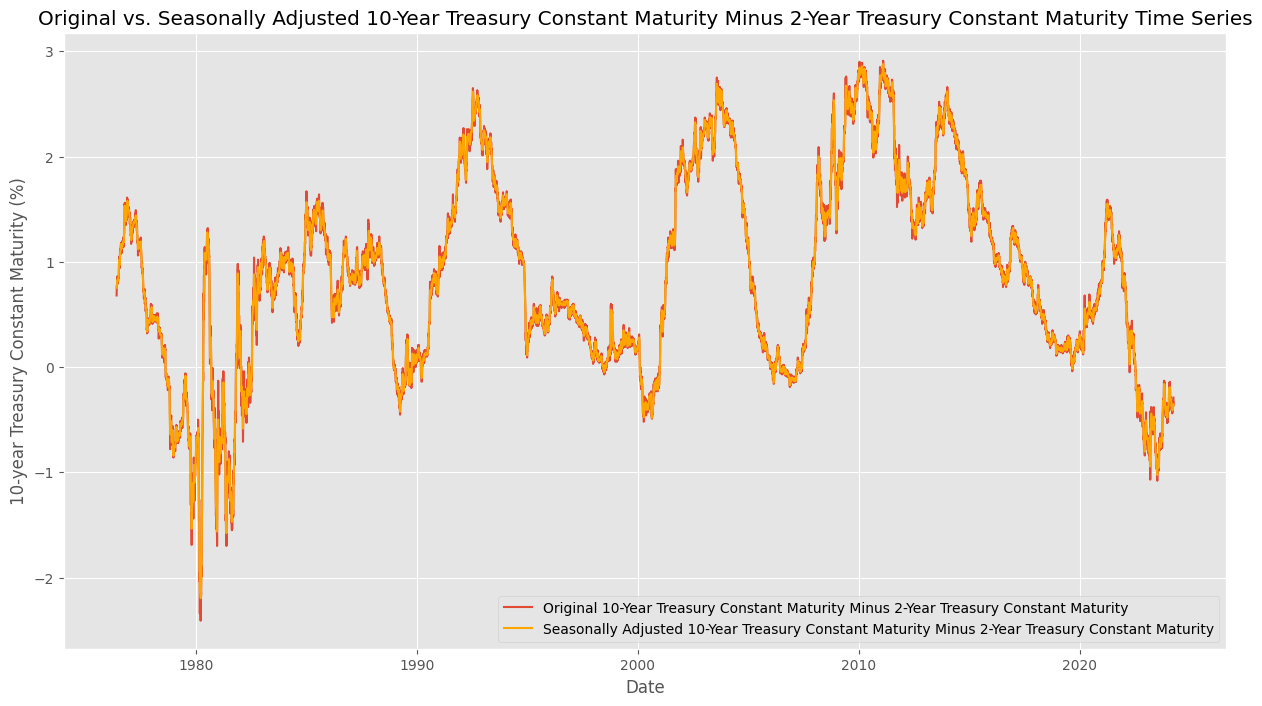

In [253]:
# Set the figure size and plot both the original and seasonally adjusted Interest Rate data on the same plot
plt.figure(figsize=(15, 8))
plt.plot(treasure_df_1['Date'], treasure_df_1['treasure_maturity'], label='Original 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity')
plt.plot(treasure_mat_adjusted['Date'], treasure_mat_adjusted['treasure_maturity'], label='Seasonally Adjusted 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity', color='orange')
plt.title('Original vs. Seasonally Adjusted 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity Time Series')
plt.xlabel('Date')
plt.ylabel('10-year Treasury Constant Maturity (%)')
plt.legend()
plt.grid(True)
plt.show()


### Inflation Rate

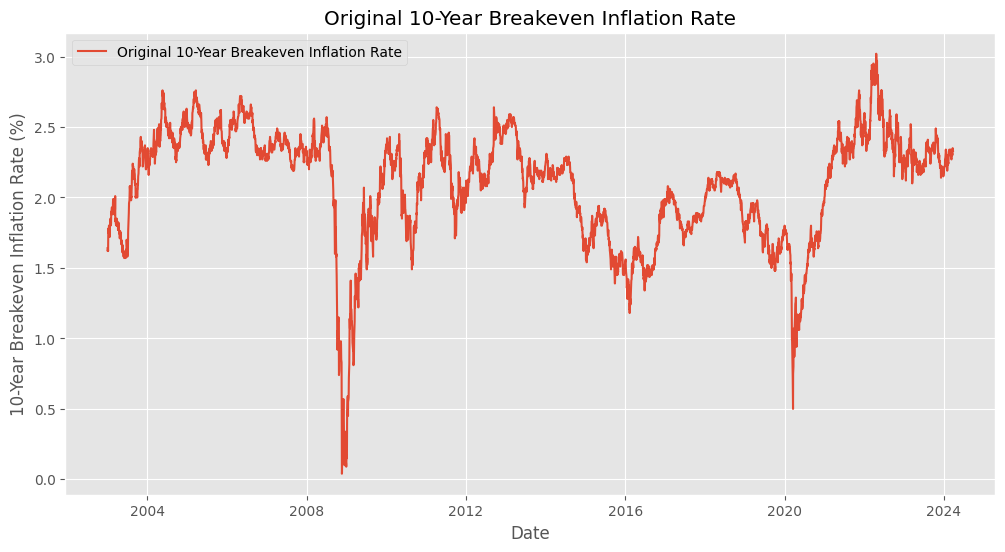

In [270]:
# Set the figure size and plot the original inflation rate
plt.figure(figsize=(12, 6))
plt.plot(inflation_df_1['Date'], inflation_df_1['inflation_rate'], label='Original 10-Year Breakeven Inflation Rate')
plt.title('Original 10-Year Breakeven Inflation Rate Time Series')
plt.xlabel('Date')
plt.ylabel('10-Year Breakeven Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

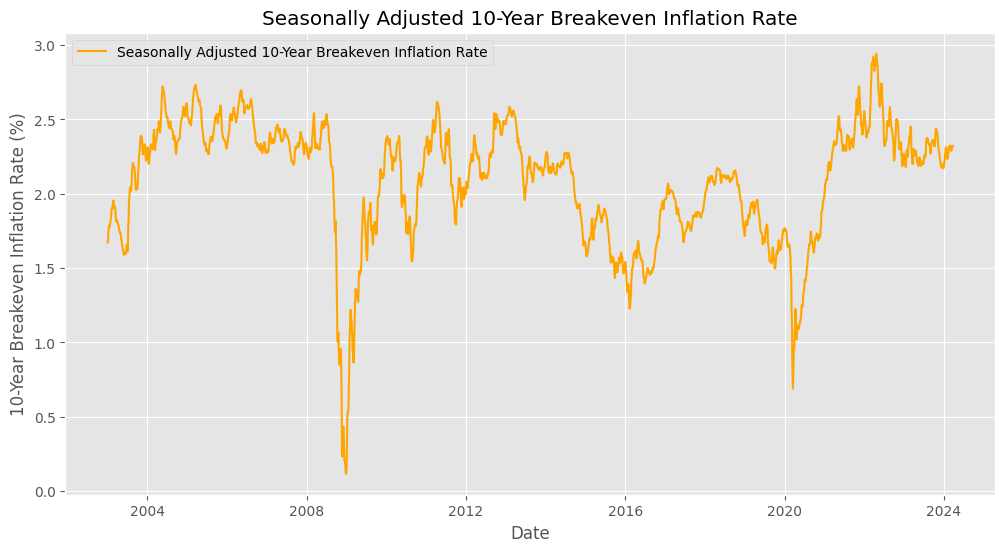

In [271]:
# Set the figure size and plot the original treasury maturity data
plt.figure(figsize=(12, 6))
plt.plot(inf_rate_adjusted['Date'], inf_rate_adjusted['inflation_rate'], label='Seasonally Adjusted 10-Year Breakeven Inflation Rate', color='orange')
plt.title('Seasonally Adjusted 10-Year Breakeven Inflation Rate Time Series')
plt.xlabel('Date')
plt.ylabel('10-Year Breakeven Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

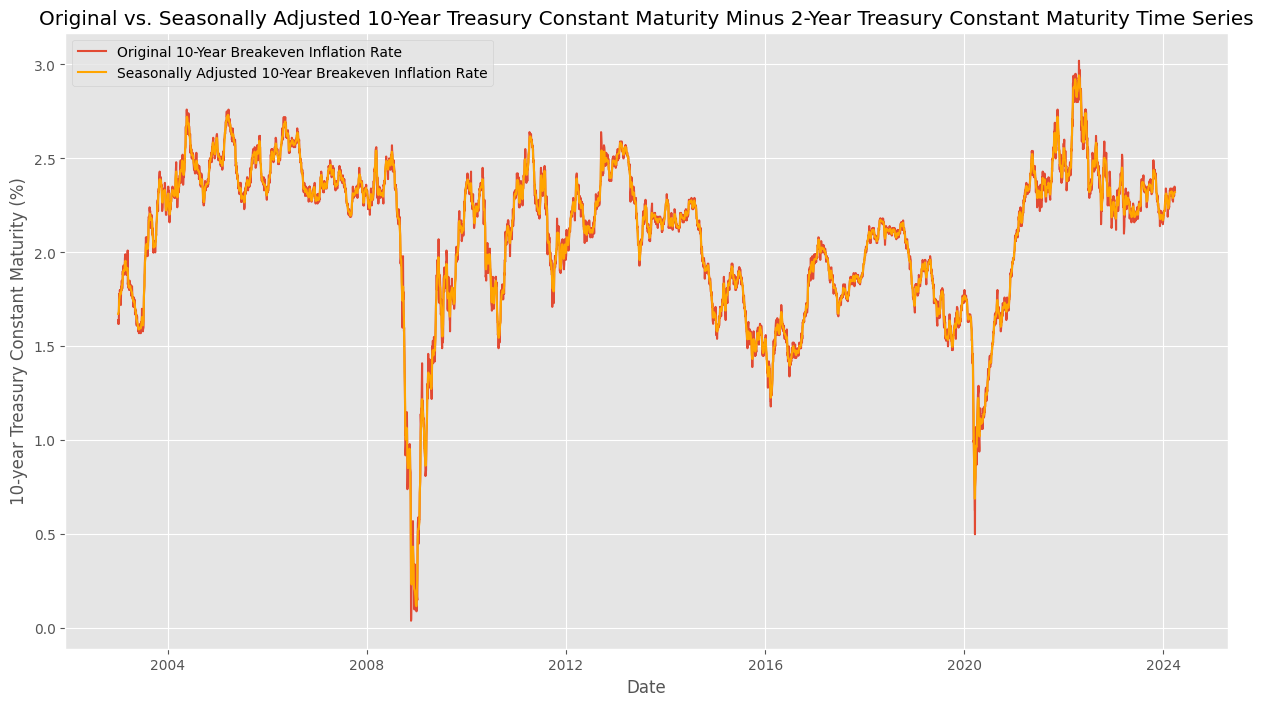

In [272]:
# Set the figure size and plot both the original and seasonally adjusted Interest Rate data on the same plot
plt.figure(figsize=(15, 8))
plt.plot(inflation_df_1['Date'], inflation_df_1['inflation_rate'], label='Original 10-Year Breakeven Inflation Rate')
plt.plot(inf_rate_adjusted['Date'], inf_rate_adjusted['inflation_rate'], label='Seasonally Adjusted 10-Year Breakeven Inflation Rate', color='orange')
plt.title('Original vs. Seasonally Adjusted 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity Time Series')
plt.xlabel('Date')
plt.ylabel('10-year Treasury Constant Maturity (%)')
plt.legend()
plt.grid(True)
plt.show()


### Sticky CPI

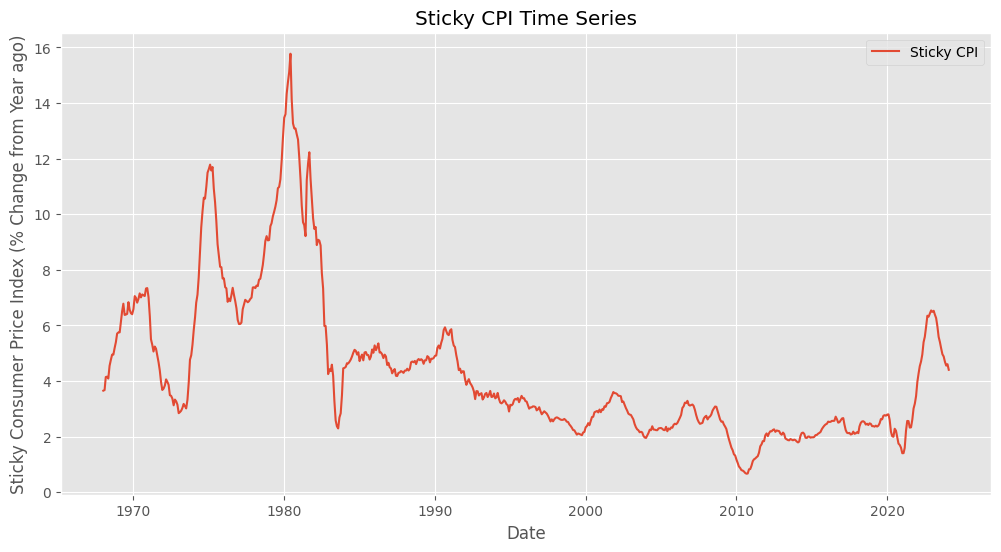

In [288]:
# Set the figure size and plot the original Sticky CPI data
plt.figure(figsize=(12, 6))
plt.plot(sticky_cpi_df_cleaned.Date, sticky_cpi_df_cleaned['sticky_cpi'], label='Sticky CPI')
plt.title('Sticky CPI Time Series')
plt.xlabel('Date')
plt.ylabel('Sticky Consumer Price Index (% Change from Year ago)')
plt.legend()
plt.grid(True)
plt.show()


### M2 Money 

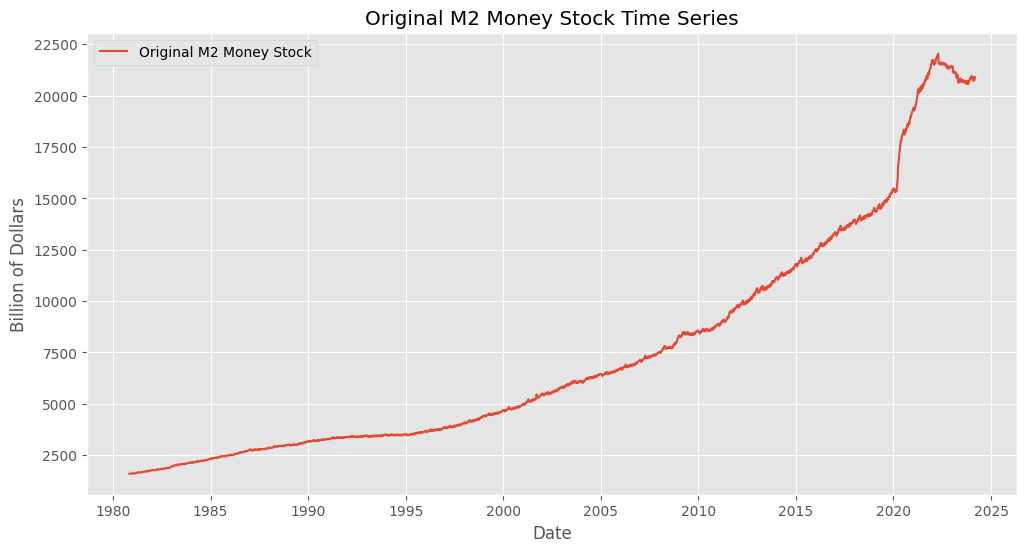

In [299]:
# Set the figure size and plot the original inflation rate
plt.figure(figsize=(12, 6))
plt.plot(m2_df_1['Date'], m2_df_1['m2_money_stock'], label='Original M2 Money Stock')
plt.title('Original M2 Money Stock Time Series')
plt.xlabel('Date')
plt.ylabel('Billion of Dollars')
plt.legend()
plt.grid(True)
plt.show()

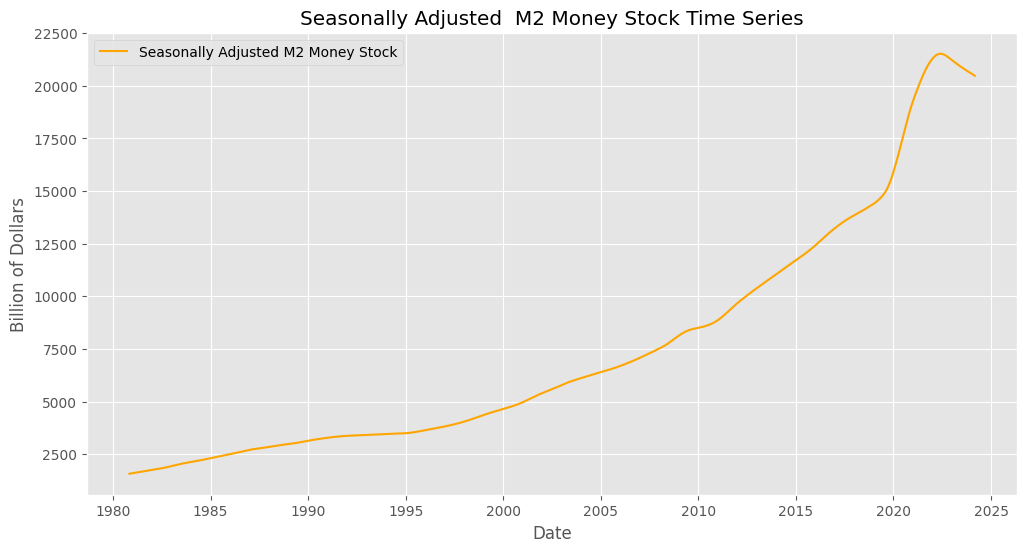

In [301]:
# Set the figure size and plot the original inflation rate
plt.figure(figsize=(12, 6))
plt.plot(m2_df_adjusted['Date'], m2_df_adjusted['m2_money_stock'], label='Seasonally Adjusted M2 Money Stock', color='orange')
plt.title('Seasonally Adjusted  M2 Money Stock Time Series')
plt.xlabel('Date')
plt.ylabel('Billion of Dollars')
plt.legend()
plt.grid(True)
plt.show()

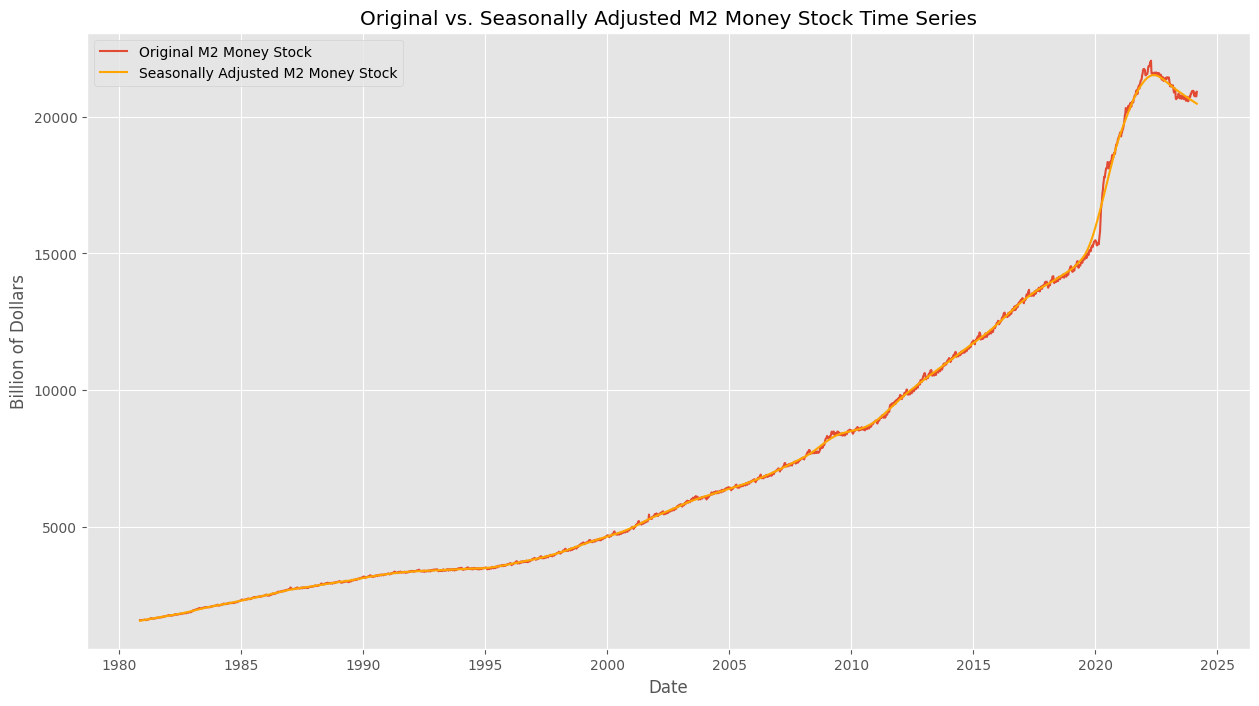

In [302]:
# Set the figure size and plot both the original and seasonally adjusted Interest Rate data on the same plot
plt.figure(figsize=(15, 8))
plt.plot(m2_df_1['Date'], m2_df_1['m2_money_stock'], label='Original M2 Money Stock')
plt.plot(m2_df_adjusted['Date'], m2_df_adjusted['m2_money_stock'], label='Seasonally Adjusted M2 Money Stock', color='orange')
plt.title('Original vs. Seasonally Adjusted M2 Money Stock Time Series')
plt.xlabel('Date')
plt.ylabel('Billion of Dollars')
plt.legend()
plt.grid(True)
plt.show()